### Load data

In [107]:
import pandas as pd 

# load and set index
df = pd.read_csv('../data/fbref/player_stats.csv')
df = df.set_index(df['Player'], drop=True)
df = df.fillna(0)

# seperate standard info and features
#l = ['unique_id','Season','League','Team','Player',	'Nation',	'Pos',	'Age', 'Global Pos',
#     "Playing Time_Starts",	"Playing Time_Min",	"Playing Time_90s"]

player_info_cols = ['unique_id','Season', 'League', 'Team', 'Player', 'Nation', 'Pos','Global Pos', 'Age','Matches Played','Playing Time_Starts','Playing Time_Min','Playing Time_90s']


player_info = df[player_info_cols]
features = [col for col in df.columns if col not in player_info_cols]
df = df[features]

# Set seed for reproducibility
SEED = 42

In [108]:
df

,Tackles_Att,Tackles_Def 3rd,Tackles_Mid 3rd,Tackles_Att 3rd,Interceptions,Clearances,Errors,Dribblers_Tkl_Succ,Dribblers_Tkl_Att,Dribblers_Tkl_Lost,...,Playing Time_Mn/MP,Starts,Mn/Start,Compl,Subs,unSub,PPM,onG,onGA,On-Off
Player,,,,,,,,,,,,,,,,,,,,,
Ederson,3.0,3.0,0.0,0.0,1.0,10.0,2.0,1.0,2.0,1.0,...,90.0,35.0,90.0,35.0,0.0,3.0,2.34,89.0,32.0,0.30
Rodri,67.0,28.0,28.0,11.0,33.0,43.0,1.0,26.0,52.0,26.0,...,81.0,34.0,85.0,23.0,2.0,1.0,2.39,83.0,26.0,1.06
Erling Haaland,3.0,0.0,2.0,1.0,3.0,14.0,0.0,1.0,5.0,4.0,...,79.0,33.0,83.0,21.0,2.0,1.0,2.37,84.0,26.0,1.47
Kevin De Bruyne,28.0,3.0,12.0,13.0,9.0,10.0,0.0,14.0,39.0,25.0,...,76.0,28.0,84.0,16.0,4.0,3.0,2.31,69.0,23.0,0.37
İlkay Gündoğan,30.0,7.0,13.0,10.0,20.0,13.0,0.0,12.0,33.0,21.0,...,76.0,27.0,85.0,17.0,4.0,7.0,2.39,71.0,20.0,1.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Rúben Alexandre Gomes Oliveira,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,...,14.0,0.0,0.0,0.0,1.0,1.0,1.00,0.0,0.0,0.95
Ricardo Fernandes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,15.0,3.00,1.0,0.0,0.00
João Afonso,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.00,0.0,0.0,0.00


### Helper functions

In [109]:
import numpy as np
def compute_cosine_similarity(embeddings):
    embeddings_norm = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
    query_embedding = embeddings_norm[1]
    cosine_similarities = np.dot(embeddings_norm, query_embedding)
    return cosine_similarities

### Scale

In [110]:
from sklearn.preprocessing import StandardScaler, Normalizer

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

In [111]:
df_scaled.shape

(4803, 137)

### PCA (optional)

In [112]:
from sklearn.decomposition import PCA

pca = PCA(n_components=25)  # Retain 95% of variance
df_pca = pca.fit_transform(df_scaled)

### Autoencoder

In [113]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

from torch.utils.data import DataLoader, TensorDataset

torch.manual_seed(SEED)
np.random.seed(SEED)

# Convert to PyTorch tensors
data_tensor = torch.tensor(df_scaled, dtype=torch.float32)

# Create a DataLoader
batch_size = 32
dataset = TensorDataset(data_tensor, data_tensor)  # Input and target are the same for autoencoder
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define model parameters
input_dim = df_scaled.shape[1]  # Input dimensions = number of features
encoding_dim = 50  # Size of the bottleneck layer

#### Model

In [114]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, encoding_dim)  # Bottleneck layer
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim),
            nn.Sigmoid()  # Output layer (reconstruction)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

#### Criterion and Optimizer

In [115]:
# model
model = Autoencoder(input_dim, encoding_dim)

# Loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss for reconstruction
optimizer = optim.Adam(model.parameters(), lr=0.001)


#### Training

In [116]:
def train_model(model, dataloader, criterion, optimizer, num_epochs=50):
    """
    Train a given model with specified parameters.

    Args:
        model: The model to train.
        dataloader: The data loader providing the input data.
        criterion: The loss function (e.g., reconstruction loss).
        optimizer: The optimizer (e.g., Adam, SGD).
        num_epochs: Number of epochs to train the model (default: 50).
        log_interval: Interval for printing the loss during training (default: 10 epochs).

    Returns:
        Trained model.
    """
    for epoch in range(num_epochs):
        for data in dataloader:
            inputs, _ = data  # Inputs are the data
            optimizer.zero_grad()

            # Forward pass: encode-decode
            outputs = model(inputs)
            loss = criterion(outputs, inputs)  # Reconstruction loss

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

        # Logging every log_interval epochs
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

    return model

model = train_model(model,dataloader,criterion,optimizer,50)

Epoch [10/50], Loss: 1.9141
Epoch [20/50], Loss: 1.7930
Epoch [30/50], Loss: 0.4700
Epoch [40/50], Loss: 0.3416
Epoch [50/50], Loss: 0.2704


In [117]:
"""# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    for data in dataloader:
        inputs, _ = data  # Inputs are the data
        optimizer.zero_grad()

        # Forward pass: encode-decode
        outputs = model(inputs)
        loss = criterion(outputs, inputs)  # Reconstruction loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")"""


'# Training loop\nnum_epochs = 50\nfor epoch in range(num_epochs):\n    for data in dataloader:\n        inputs, _ = data  # Inputs are the data\n        optimizer.zero_grad()\n\n        # Forward pass: encode-decode\n        outputs = model(inputs)\n        loss = criterion(outputs, inputs)  # Reconstruction loss\n\n        # Backward pass and optimization\n        loss.backward()\n        optimizer.step()\n\n    if (epoch + 1) % 10 == 0:\n        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")'

#### Bottleneck Layer

In [118]:
# Extract reduced embeddings
with torch.no_grad():  # No need to track gradients for inference
    embeddings = model.encoder(data_tensor).numpy()

# Normalize the embeddings (L2 normalization)
embeddings_norm = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)


#### Compute cosine

In [132]:
# Let's say the first row is the query point
query_embedding = embeddings_norm[795]

# Compute cosine similarities between the query and the rest
cosine_similarities = np.dot(embeddings_norm, query_embedding)

# Get the top 10 most similar samples
top_10_similar = np.argsort(cosine_similarities)[-20:]
top_10_df = player_info.iloc[top_10_similar].copy()
top_10_df['cosine_similarity'] = cosine_similarities[top_10_similar]

top_10_df = top_10_df.sort_values('cosine_similarity',ascending=False)
display(top_10_df.drop(columns='unique_id'))

,Season,League,Team,Player,Nation,Pos,Global Pos,Age,Matches Played,Playing Time_Starts,Playing Time_Min,Playing Time_90s,cosine_similarity
Player,,,,,,,,,,,,,
Christopher Nkunku,2022-2023,Bundesliga,RB Leipzig,Christopher Nkunku,FRA,"FW,MF",FW,24.0,25.0,20.0,1897.0,21.1,1.000000
Randal Kolo Muani,2022-2023,Bundesliga,Eint Frankfurt,Randal Kolo Muani,FRA,FW,FW,23.0,32.0,31.0,2631.0,29.2,0.981466
Ciro Immobile,2022-2023,SeriaA,Lazio,Ciro Immobile,ITA,FW,FW,32.0,31.0,27.0,2219.0,24.7,0.980551
Robert Lewandowski,2022-2023,LaLiga,Barcelona,Robert Lewandowski,POL,FW,FW,33.0,34.0,33.0,2847.0,31.6,0.977700
Nicolas Jackson,2022-2023,LaLiga,Villarreal,Nicolas Jackson,SEN,FW,FW,21.0,26.0,16.0,1598.0,17.8,0.973752
Dango Ouattara,2022-2023,Ligue1,Lorient,Dango Ouattara,BFA,"FW,MF",FW,20.0,18.0,18.0,1548.0,17.2,0.973605
Amine Adli,2022-2023,Bundesliga,Leverkusen,Amine Adli,MAR,"FW,MF",FW,22.0,26.0,16.0,1435.0,15.9,0.973033
Erling Haaland,2022-2023,EPL,Manchester City,Erling Haaland,NOR,FW,FW,22.0,35.0,33.0,2769.0,30.8,0.972845
Rafa Silva,2022-2023,PrimeiraLiga,Benfica,Rafa Silva,POR,"MF,FW",MF,29.0,28.0,26.0,2174.0,24.2,0.971533


### Weighted Autoencoder

By adding a weights to MSE we can emphazise more on certain features.
This may help to take individual requirements more into account e.g. a coach wants a player like Rodri especially like certain attributes.
In this case chapter we emphazise on 'Receiving_Succ', 'Shots'.


In [120]:
# focus on carry dimension
weight_dimension= ['Carries_TotDist', 'Carries_PrgDist', 'Carries_PrgC', 'Carries_1/3']

start_idx = df.columns.get_loc(weight_dimension[0])
end_idx = df.columns.get_loc(weight_dimension[-1])
start_idx, end_idx

(23, 26)

In [121]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

from torch.utils.data import DataLoader, TensorDataset

torch.manual_seed(SEED)
np.random.seed(SEED)

# Convert to PyTorch tensors
data_tensor = torch.tensor(df_scaled, dtype=torch.float32)

# Create a DataLoader
batch_size = 32
dataset = TensorDataset(data_tensor, data_tensor)  # Input and target are the same for autoencoder
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

#### Weighted criterion

In [122]:
# Define a custom weighted MSE loss function
class WeightedMSELoss(nn.Module):
    def __init__(self, feature_weights):
        super(WeightedMSELoss, self).__init__()
        self.feature_weights = torch.tensor(feature_weights, dtype=torch.float32)
    
    def forward(self, output, target):
        # Compute the MSE loss
        mse_loss = nn.MSELoss(reduction='none')(output, target)
        # Apply the feature weights
        weighted_loss = mse_loss * self.feature_weights
        # Return the mean of the weighted losses
        return weighted_loss.mean()
    
# Define feature weights (example: give higher weights to features 0 and 1)
feature_weights = [1] * df.shape[1]
#feature_weights[157] = 10.0

for i in range(start_idx, end_idx + 1):
    feature_weights[i] =  1.0


# Instantiate the custom loss function
weighted_criterion = WeightedMSELoss(feature_weights)
feature_weights

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1.0,
 1.0,
 1.0,
 1.0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

#### Training

In [126]:
# Initialize weights
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)


# model parameters
input_dim = df_scaled.shape[1]
encoding_dim = 50  # bottleneck layer

# Instantiate the model
model = Autoencoder(input_dim, encoding_dim)
model.apply(initialize_weights)

# Loss function and optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

model = train_model(model, dataloader, weighted_criterion, optimizer, 5)

#### Compute cosine - Top k

In [130]:
# Extract reduced embeddings
with torch.no_grad():  # No need to track gradients for inference
    embeddings = model.encoder(data_tensor).numpy()

# Normalize the embeddings (L2 normalization)
embeddings_norm = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)

# Let's say the first row is the query point
query_embedding = embeddings_norm[795]

# Compute cosine similarities between the query and the rest
cosine_similarities = np.dot(embeddings_norm, query_embedding)

# Get the top 10 most similar samples
top_10_similar = np.argsort(cosine_similarities)[-20:]
top_10_df = player_info.iloc[top_10_similar].copy()
top_10_df['cosine_similarity'] = cosine_similarities[top_10_similar]
top_10_df = top_10_df.sort_values('cosine_similarity',ascending=False)
display(top_10_df.drop(columns='unique_id'))

,Season,League,Team,Player,Nation,Pos,Global Pos,Age,Matches Played,Playing Time_Starts,Playing Time_Min,Playing Time_90s,cosine_similarity
Player,,,,,,,,,,,,,
Christopher Nkunku,2022-2023,Bundesliga,RB Leipzig,Christopher Nkunku,FRA,"FW,MF",FW,24.0,25.0,20.0,1897.0,21.1,1.000000
Randal Kolo Muani,2022-2023,Bundesliga,Eint Frankfurt,Randal Kolo Muani,FRA,FW,FW,23.0,32.0,31.0,2631.0,29.2,0.981466
Ciro Immobile,2022-2023,SeriaA,Lazio,Ciro Immobile,ITA,FW,FW,32.0,31.0,27.0,2219.0,24.7,0.980551
Robert Lewandowski,2022-2023,LaLiga,Barcelona,Robert Lewandowski,POL,FW,FW,33.0,34.0,33.0,2847.0,31.6,0.977700
Nicolas Jackson,2022-2023,LaLiga,Villarreal,Nicolas Jackson,SEN,FW,FW,21.0,26.0,16.0,1598.0,17.8,0.973752
Dango Ouattara,2022-2023,Ligue1,Lorient,Dango Ouattara,BFA,"FW,MF",FW,20.0,18.0,18.0,1548.0,17.2,0.973605
Amine Adli,2022-2023,Bundesliga,Leverkusen,Amine Adli,MAR,"FW,MF",FW,22.0,26.0,16.0,1435.0,15.9,0.973033
Erling Haaland,2022-2023,EPL,Manchester City,Erling Haaland,NOR,FW,FW,22.0,35.0,33.0,2769.0,30.8,0.972845
Rafa Silva,2022-2023,PrimeiraLiga,Benfica,Rafa Silva,POR,"MF,FW",MF,29.0,28.0,26.0,2174.0,24.2,0.971533


#### Cosine on weighted features

In [128]:
weight_dimension_df = top_10_df[weight_dimension]

embeddings_norm = weight_dimension_df / np.linalg.norm(weight_dimension_df, axis=1, keepdims=True)
player_vector = embeddings_norm.loc['Christopher Nkunku']

cosine_similarities = np.dot(embeddings_norm, player_vector)

cosine_sim_df = pd.DataFrame(cosine_similarities, index=weight_dimension_df.index, columns=['Cosine Similarity'])

weight_dimension_df['Cosine Similarity'] = cosine_sim_df
weight_dimension_df

KeyError: "None of [Index(['Carries_TotDist', 'Carries_PrgDist', 'Carries_PrgC', 'Carries_1/3'], dtype='object')] are in the [columns]"

#### Visualize similar player

<Axes: xlabel='Carries_TotDist', ylabel='Carries_1/3'>

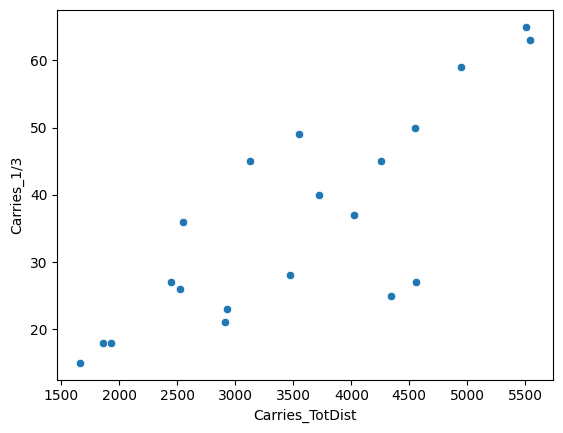

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(x=weight_dimension_df['Carries_TotDist'],y=weight_dimension_df['Carries_1/3'])


#### Euclidean Distance

In [103]:
similar_players

,Distance
Player,
Christopher Nkunku,0.000000
Arnaud Nordin,12.742574
Ivan Jaime Pajuelo,12.775982
David Okereke,13.689649
Rafa Silva,13.705217
...,...
Sander Sybrandy,98.788834
Antonio Gomis,99.210724
Mohamed El Arouch,101.070465


In [102]:
from sklearn.metrics.pairwise import euclidean_distances

query_embedding = embeddings[795].reshape(1, -1)

# Compute Euclidean distances
distances = euclidean_distances(query_embedding, embeddings)

# Create a DataFrame of distances
distance_df = pd.DataFrame(distances.flatten(), index=df.index, columns=['Distance'])
similar_players = distance_df.sort_values(by='Distance')

similar_players.head(20)


,Distance
Player,
Christopher Nkunku,0.000000
Arnaud Nordin,12.742574
Ivan Jaime Pajuelo,12.775982
David Okereke,13.689649
Rafa Silva,13.705217
Santiago Giménez,14.341222
Ciro Immobile,15.325940
Fran Navarro,15.363972
Donyell Malen,15.486386


#### KNN

In [98]:
from sklearn.neighbors import NearestNeighbors

# model 
knn = NearestNeighbors(n_neighbors=30, metric='euclidean')  # n_neighbors=2 because the closest will include itself
knn = knn.fit(embeddings)

query_embedding = embeddings[795].reshape(1, -1)

distances, indices = knn.kneighbors(query_embedding)

# Output the most similar player (excluding Christopher Nkunku itself)
nearest_neighbor_index = indices[0] # [1] because [0] will be Nkunku himself

result_df = player_info.iloc[nearest_neighbor_index]
result_df['Distance'] = distances[0]
result_df.drop(columns='unique_id')

C:\Users\Alexander Lorenz\AppData\Local\Temp\ipykernel_19352\2320104197.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['Distance'] = distances[0]


,Season,League,Team,Player,Nation,Pos,Global Pos,Age,Matches Played,Playing Time_Starts,Playing Time_Min,Playing Time_90s,Distance
Player,,,,,,,,,,,,,
Christopher Nkunku,2022-2023,Bundesliga,RB Leipzig,Christopher Nkunku,FRA,"FW,MF",FW,24.0,25.0,20.0,1897.0,21.1,6.743496e-07
Arnaud Nordin,2022-2023,Ligue1,Montpellier,Arnaud Nordin,FRA,FW,FW,24.0,36.0,30.0,2401.0,26.7,1.274257e+01
Ivan Jaime Pajuelo,2022-2023,PrimeiraLiga,Famalicão,Ivan Jaime Pajuelo,ESP,"FW,MF",FW,21.0,24.0,21.0,1869.0,20.8,1.277598e+01
David Okereke,2022-2023,SeriaA,Cremonese,David Okereke,NGA,"FW,MF",FW,24.0,33.0,25.0,2266.0,25.2,1.368965e+01
Rafa Silva,2022-2023,PrimeiraLiga,Benfica,Rafa Silva,POR,"MF,FW",MF,29.0,28.0,26.0,2174.0,24.2,1.370522e+01
Santiago Giménez,2022-2023,EreDivisie,Feyenoord,Santiago Giménez,MEX,FW,FW,21.0,32.0,21.0,1926.0,21.4,1.434122e+01
Ciro Immobile,2022-2023,SeriaA,Lazio,Ciro Immobile,ITA,FW,FW,32.0,31.0,27.0,2219.0,24.7,1.532594e+01
Fran Navarro,2022-2023,PrimeiraLiga,Gil Vicente FC,Fran Navarro,ESP,FW,FW,24.0,34.0,34.0,3031.0,33.7,1.536397e+01
Donyell Malen,2022-2023,Bundesliga,Dortmund,Donyell Malen,NED,FW,FW,23.0,26.0,22.0,1706.0,19.0,1.548639e+01
